In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Model들을 import

In [2]:
import keras
import glob
import natsort
import matplotlib.pyplot as plt
import cv2
import numpy as np
import json
import tensorflow as tf

from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras import backend as K

# 2. 데이터 불러오기

### 일단 테스트용으로 2개만 불러와 봅시다.   
일반 정상 데이터와 COVID-19 환자의 데이터를 불러와 보겠습니다.

# 3. ImageDataGenerator를 사용하자!

255로 나워주는 normalization 작업과, horizontal flip의 2가지 옵션을 적용하였습니다.   
본래 rotation, zoom 등의 옵션도 있었으나, 빼는 것이 훨씬 결과가 좋아 빼게 되었습니다.   
   
   validation data는 전체 훈련 data 중 20%만 사용하였습니다.

In [3]:
from keras.preprocessing.image import ImageDataGenerator

# train 데이터를 위한 generator
generator_1 = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip = True,
    validation_split=0.2)

# validation 데이터를 위한 generator
generator_2 = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip = True,
    validation_split=0.2)


# test 데이터를 위한 generator
generator_3 = ImageDataGenerator(rescale=1./255)

원본 이미지가 299 * 299이므로, 300 * 300으로 읽어옵시다.

In [ ]:
# local의 경우

train_generator = generator_1.flow_from_directory(
    './COVID19/train',
    target_size=(300, 300),
    class_mode='binary',
    batch_size=2,
    shuffle=True,
    seed = 77, subset='training')

validation_generator = generator_2.flow_from_directory(
    './COVID19/train',
    target_size=(300, 300),
    class_mode='binary',
    batch_size=2,
    shuffle=True,
    seed = 77, subset='validation')

Found 10886 images belonging to 2 classes.
Found 2721 images belonging to 2 classes.


In [4]:
# google drive의 경우

train_generator = generator_1.flow_from_directory(
    '/content/drive/MyDrive/Classification/COVID19/train_data',
    target_size=(300, 300),
    class_mode='binary',
    batch_size=2,
    shuffle=True,
    seed = 77, subset='training')

validation_generator = generator_2.flow_from_directory(
    '/content/drive/MyDrive/Classification/COVID19/train_data',
    target_size=(300, 300),
    class_mode='binary',
    batch_size=2,
    shuffle=True,
    seed = 77, subset='validation')

Found 5626 images belonging to 2 classes.
Found 1406 images belonging to 2 classes.


# 4. 학습용 model 설계

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

# conv layer들을 사용한 단순한 네트워크를 구성함.
model = Sequential()

model.add(layers.InputLayer(input_shape=(300,300,3)))
model.add(layers.Conv2D(256, (3, 3), (1, 1), 'same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(rate=0.3))

model.add(layers.Conv2D(128, (3, 3), (1, 1), 'same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(rate=0.3))

model.add(layers.Conv2D(64, (3, 3), (1, 1), 'same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(rate=0.3))

model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 300, 300, 256)     7168      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 150, 150, 256)     0         
_________________________________________________________________
dropout (Dropout)            (None, 150, 150, 256)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 128)     295040    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 75, 75, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 64)        7

* 그래프 시각화

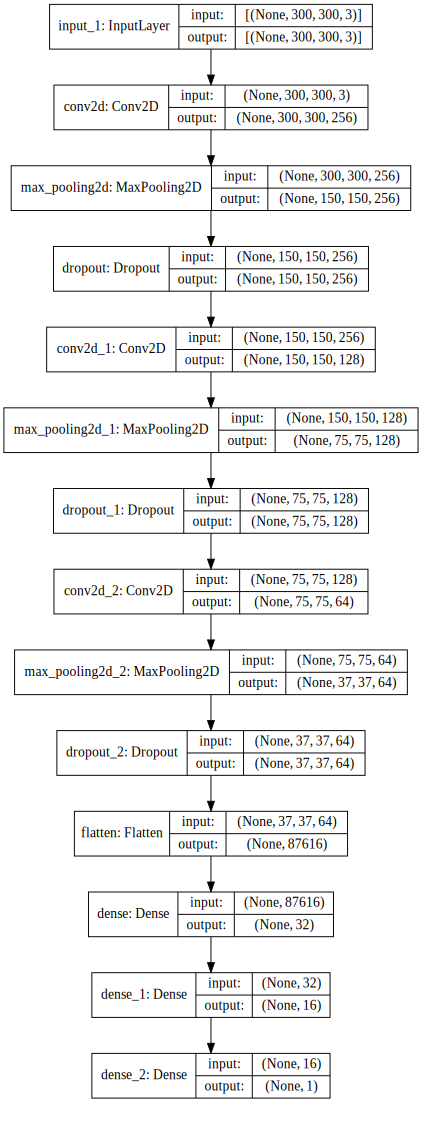

In [7]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

SVG(model_to_dot(model, show_shapes=True, dpi = 70).create(prog='dot', format='svg'))

In [8]:
# optimizer는 adam을 사용하였고, loss의 경우, 우선 2개의 class이므로 binarycrossentropy,
# 학습에서 볼 metric으로는 accuracy를 사용하였습니다.

model.compile(optimizer = 'adam',
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = ['accuracy'])

테스트로 40 에포크만 학습해 보기

In [9]:
history = model.fit(train_generator,
        steps_per_epoch=24, epochs=40,
        validation_data = validation_generator,
        validation_steps=24)

Epoch 1/40
24/24 [==============================] - 75s 3s/step - loss: 0.9182 - accuracy: 0.5000 - val_loss: 0.6933 - val_accuracy: 0.3958
Epoch 2/40
24/24 [==============================] - 73s 3s/step - loss: 0.6939 - accuracy: 0.5625 - val_loss: 0.6924 - val_accuracy: 0.6667
Epoch 3/40
24/24 [==============================] - 73s 3s/step - loss: 0.6923 - accuracy: 0.5833 - val_loss: 0.6885 - val_accuracy: 0.5000
Epoch 4/40
24/24 [==============================] - 76s 3s/step - loss: 0.7018 - accuracy: 0.4583 - val_loss: 0.6930 - val_accuracy: 0.5208
Epoch 5/40
24/24 [==============================] - 73s 3s/step - loss: 0.6982 - accuracy: 0.4375 - val_loss: 0.6934 - val_accuracy: 0.4583
Epoch 6/40
24/24 [==============================] - 74s 3s/step - loss: 0.6925 - accuracy: 0.5625 - val_loss: 0.6943 - val_accuracy: 0.3958
Epoch 7/40
24/24 [==============================] - 74s 3s/step - loss: 0.6928 - accuracy: 0.5417 - val_loss: 0.6922 - val_accuracy: 0.5625
Epoch 8/40
24/24 [==

In [10]:
test_result = history.history

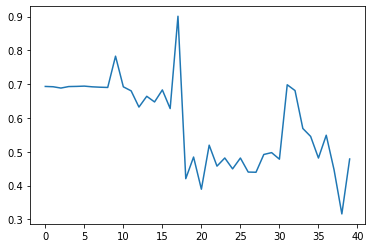

In [11]:
plt.plot(test_result['val_loss'])

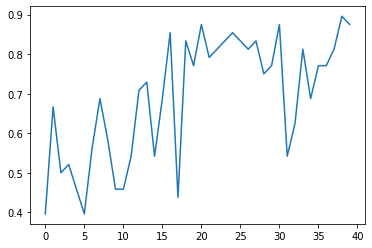

In [12]:
plt.plot(test_result['val_accuracy'])

### 일단 epoch의 수가 적어 요동은 치지만, 확실히 loss는 내려가고 accuracy는 올라가는 것을 볼 수 있습니다.

여기에서, 이미지의 class 수를 3가지로 해 보았습니다.   
본래 Viral pneumonia 환자 데이터의 수가 적으므로 다른 데에서 데이터를 추가하려 하였으나,   
이미지의 크기가 기존 dataset과 달라 결과가 좋지 않아 그냥 빼게 되었습니다.

1. train   
 - Normal : 10092장
 - COVID : 3516장
 - Viral pneumonia : 1245장   

2. test   
각 class별로 100장씩을 빼서 test set을 구성함.

In [ ]:
# generator 다시 정의

train_generator_2 = generator_1.flow_from_directory(
    '/content/drive/MyDrive/Classification/COVID-19_Radiography_Dataset/train',
    target_size=(300, 300),
    class_mode='categorical',
    batch_size=24,
    shuffle=True,
    seed = 77, subset='training')

validation_generator_2 = generator_2.flow_from_directory(
    '/content/drive/MyDrive/Classification/COVID-19_Radiography_Dataset/train',
    target_size=(300, 300),
    class_mode='categorical',
    batch_size=24,
    shuffle=True,
    seed = 77, subset='validation')

Found 11915 images belonging to 3 classes.
Found 2978 images belonging to 3 classes.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

model_2 = Sequential()

model_2.add(layers.InputLayer(input_shape=(300,300,3)))
model_2.add(layers.Conv2D(256, (3, 3), (1, 1), 'same', activation='relu'))
model_2.add(layers.MaxPooling2D((2, 2)))
model_2.add(layers.Dropout(rate=0.3))

model_2.add(layers.Conv2D(128, (3, 3), (1, 1), 'same', activation='relu'))
model_2.add(layers.MaxPooling2D((2, 2)))
model_2.add(layers.Dropout(rate=0.3))

model_2.add(layers.Conv2D(64, (3, 3), (1, 1), 'same', activation='relu'))
model_2.add(layers.MaxPooling2D((2, 2)))
model_2.add(layers.Dropout(rate=0.3))

model_2.add(layers.Flatten())
model_2.add(layers.Dense(32, activation='relu'))
model_2.add(layers.Dense(16, activation='relu'))

# categorical classification이기 때문에, sigmoid 대신 softmax를 사용합니다.
model_2.add(layers.Dense(3, activation='softmax'))

# 5. 3개의 class를 불러와서 학습해 보기.

In [ ]:
train_generator_2 = generator_1.flow_from_directory(
    './COVID-19_Radiography_Dataset/train',
    target_size=(300, 300),
    class_mode='categorical',
    batch_size=24,
    shuffle=True,
    seed = 77, subset='training')

validation_generator_2 = generator_2.flow_from_directory(
    './COVID-19_Radiography_Dataset/train',
    target_size=(300, 300),
    class_mode='categorical',
    batch_size=24,
    shuffle=True,
    seed = 77, subset='validation')

Found 11915 images belonging to 3 classes.
Found 2978 images belonging to 3 classes.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

model_2 = Sequential()

model_2.add(layers.InputLayer(input_shape=(300,300,3)))
model_2.add(layers.Conv2D(256, (3, 3), (1, 1), 'same', activation='relu'))
model_2.add(layers.MaxPooling2D((2, 2)))
model_2.add(layers.Dropout(rate=0.3))

model_2.add(layers.Conv2D(128, (3, 3), (1, 1), 'same', activation='relu'))
model_2.add(layers.MaxPooling2D((2, 2)))
model_2.add(layers.Dropout(rate=0.3))

model_2.add(layers.Conv2D(64, (3, 3), (1, 1), 'same', activation='relu'))
model_2.add(layers.MaxPooling2D((2, 2)))
model_2.add(layers.Dropout(rate=0.3))

model_2.add(layers.Flatten())
model_2.add(layers.Dense(32, activation='relu'))
model_2.add(layers.Dense(16, activation='relu'))

# categorical classification이기 때문에, sigmoid 대신 softmax를 사용합니다.
model_2.add(layers.Dense(3, activation='softmax'))

In [ ]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 300, 300, 256)     7168      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 150, 150, 256)     0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 150, 150, 256)     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 150, 150, 128)     295040    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 75, 75, 128)       0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 75, 75, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 75, 75, 64)       

In [ ]:
# 이제, class가 3개이므로 categorical crossentropy를 loss로 사용합니다.

model_2.compile(optimizer = 'adam', loss = tf.keras.losses.CategoricalCrossentropy(), metrics = ['accuracy'])

callback 함수 만들어주기

In [ ]:
import keras
import tensorflow as tf

from keras.callbacks import CSVLogger

# loss가 최소인 epoch를 기록할 callback
loss_callbacks = keras.callbacks.ModelCheckpoint(
                      filepath = './history/loss.h5',
                      monitor = 'val_loss',
                      save_best_only = True)

# acc가 최대인 epoch를 기록할 callback
acc_callbacks = keras.callbacks.ModelCheckpoint(
                      filepath = './history/acc.h5',
                      monitor = 'val_accuracy',
                      save_best_only = True)

# 전체 학습 과정을 csvlogger를 사용해 csv로 기록
csv_logger = CSVLogger('./history/log.csv', append=True)

In [ ]:
# 위 3개의 callback들을 callbacks_list라는 하나의 리스트로 묶어 줍니다.

callbacks_list = [loss_callbacks, acc_callbacks, csv_logger]

### 200 epoch 훈련

In [ ]:
history_2 = model_2.fit(train_generator_2,
        steps_per_epoch=24, epochs=200,
        validation_data = validation_generator_2,
        validation_steps=24, callbacks = callbacks_list)

Epoch 1/200
24/24 [==============================] - 5s 163ms/step - loss: 1.5842 - accuracy: 0.6562 - val_loss: 0.8139 - val_accuracy: 0.6615
Epoch 2/200
24/24 [==============================] - 4s 154ms/step - loss: 0.7330 - accuracy: 0.6632 - val_loss: 0.8194 - val_accuracy: 0.7118
Epoch 3/200
24/24 [==============================] - 4s 152ms/step - loss: 0.6258 - accuracy: 0.7049 - val_loss: 0.6483 - val_accuracy: 0.7743
Epoch 4/200
24/24 [==============================] - 4s 154ms/step - loss: 0.6206 - accuracy: 0.7031 - val_loss: 0.6346 - val_accuracy: 0.7274
Epoch 5/200
24/24 [==============================] - 4s 159ms/step - loss: 0.5300 - accuracy: 0.7500 - val_loss: 0.5743 - val_accuracy: 0.7049
Epoch 6/200
24/24 [==============================] - 4s 155ms/step - loss: 0.5538 - accuracy: 0.7535 - val_loss: 0.5727 - val_accuracy: 0.7257
Epoch 7/200
24/24 [==============================] - 4s 155ms/step - loss: 0.5133 - accuracy: 0.7778 - val_loss: 0.5092 - val_accuracy: 0.7639

# 6. history plot해 보기

In [ ]:
history_dict = history_2.history

# history를 json 형식으로 저장
json.dump(history_dict, open("./history/1021_100epoch.json", 'w'))

# 전체 훈련 과정을 거친 model과 model weight도 save
model_2.save("./history/1021_200epoch")
model_2.save_weights("./history/1021_200epoch.h5")

INFO:tensorflow:Assets written to: ./history/1021_200epoch/assets


In [ ]:
result = history_2.history

### loss와 accuracy를 plot해 보기

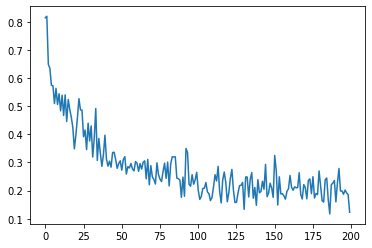

In [ ]:
plt.plot(result['val_loss'])

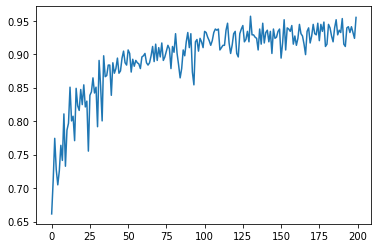

In [ ]:
plt.plot(result['val_accuracy'])

### 꽤나 만족스러운 그래프를 그린 것을 볼 수 있습니다.

# =============================

# 7. 테스트해 보기

우선, 저장한 log.csv를 불러와 보겠습니다.

In [ ]:
import pandas as pd

# csv 블러오기
log_df = pd.read_csv('./history/log.csv')

# 맨 위의 5개만 한 번 보기
log_df.head(5)

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.656250,1.584192,0.661458,0.813916
1,1,0.663194,0.733018,0.711806,0.819356
2,2,0.704861,0.625793,0.774306,0.648339
3,3,0.703125,0.620557,0.727431,0.634580
4,4,0.750000,0.530025,0.704861,0.574342


## 이제 이 csv를 통해 loss와 accuracy가 각각 몇 epoch에서 최고 기록을 내었는지 보도록 합니다.

In [ ]:
# loss가 최소인 epoch 뽑기
a = log_df.iloc[[log_df.val_loss.idxmin()]]["epoch"]

# accuracy가 최대인 epoch 뽑기
b = log_df.iloc[[log_df.val_accuracy.idxmax()]]["epoch"]

In [ ]:
# 각각의 값들도 뽑아봅시다.

print('loss가 최소인 epoch = ' + str(int(a)) + 'epoch, value : ' + str(log_df['val_loss'][int(a)]))
print('accuracy가 최고인 epoch = ' + str(int(b)) + 'epoch, value : ' + str(log_df['val_accuracy'][int(b)]))

loss가 최소인 epoch = 186epoch, value : 0.1173232421278953
accuracy가 최고인 epoch = 130epoch, value : 0.9565972089767456


## 모델을 하나 더 짭니다. 여기서 loss가 최소인 model의 weight를 불러오도록 하겠습니다.

In [ ]:
model_3 = Sequential()

model_3.add(layers.InputLayer(input_shape=(299,299,3)))
model_3.add(layers.Conv2D(256, (3, 3), (1, 1), 'same', activation='relu'))
model_3.add(layers.MaxPooling2D((2, 2)))
model_3.add(layers.Dropout(rate=0.3))

model_3.add(layers.Conv2D(128, (3, 3), (1, 1), 'same', activation='relu'))
model_3.add(layers.MaxPooling2D((2, 2)))
model_3.add(layers.Dropout(rate=0.3))

model_3.add(layers.Conv2D(64, (3, 3), (1, 1), 'same', activation='relu'))
model_3.add(layers.MaxPooling2D((2, 2)))
model_3.add(layers.Dropout(rate=0.3))

model_3.add(layers.Flatten())
model_3.add(layers.Dense(32, activation='relu'))
model_3.add(layers.Dense(16, activation='relu'))
model_3.add(layers.Dense(3, activation='softmax'))

loss가 최소인 model의 weight 불러오기

In [ ]:
model_3.load_weights('./history/loss.h5')

In [ ]:
model_3.compile(optimizer = 'adam', loss = tf.keras.losses.CategoricalCrossentropy(), metrics = ['accuracy'])

In [ ]:
model_3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 299, 299, 256)     7168      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 149, 149, 256)     0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 149, 149, 256)     0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 149, 149, 128)     295040    
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 74, 74, 128)       0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 74, 74, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 74, 74, 64)       

test data 이미지들을 불러오기

In [ ]:
test_img = glob.glob('./COVID-19_Radiography_Dataset/test/*/*')

# natsort를 이용해 알파벳 순서대로 정리해 줍니다.
test_img = natsort.natsorted(test_img)

### natsorted로 정렬된 순서 : COVID, Normal, Viral Pneumonia

In [ ]:
len(test_img)

300

In [ ]:
# 빈 array를 만들고, 300장의 이미지를 차례대로 불러와서 리스트에 append해 줍시다.

test_array = []

for i in range(300):
    a = cv2.imread(test_img[i])
    a_1 = a/255.
    a_1 = a[:, :, ::-1]
    
    test_array.append(a_1)

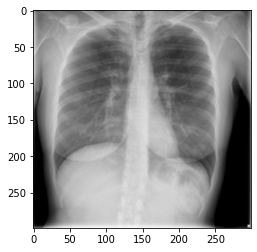

In [ ]:
# 하나 띄워보기

plt.imshow(test_array[0])

In [ ]:
# 이후, 학습에 사용하기 위해 numpy array로 만들어 줍니다.

test_array = np.array(test_array)

In [ ]:
test_array.shape

(300, 299, 299, 3)

In [ ]:
# 300장의 이미지를 싹 predict

result = model_3.predict(test_array)

In [ ]:
q = 0

print( test_img[q] )
print( result[q] )

./COVID-19_Radiography_Dataset/test/COVID/COVID-3516.png
[1. 0. 0.]


# natsorted로 정렬된 순서 : COVID, Normal, Viral Pneumonia

### 원 핫 인코딩을 보면, COVID 환자의 data로 분류를 했음을 볼 수 있습니다.

In [ ]:
# COVID 환자의 data 불러오기

q = 0

print( test_img[q] )
print( result[q] )

./COVID-19_Radiography_Dataset/test/COVID/COVID-3516.png
[1. 0. 0.]


In [ ]:
# Normal 환자의 data 불러오기

q = 160

print( test_img[q] )
print( result[q] )

./COVID-19_Radiography_Dataset/test/Normal/Normal-10153.png
[0. 1. 0.]


In [ ]:
# Viral pneumonia 환자의 data 불러오기

q = 250

print( test_img[q] )
print( result[q] )

./COVID-19_Radiography_Dataset/test/Viral Pneumonia/Viral Pneumonia-1296.png
[0. 0. 1.]


## COVID와 Viral Pneumonia, Normal data를 각각 정확히 분류한 것을 알 수 있었습니다.

# ======================================================

# 8. Heatmap 그려 보기

77번째 이미지를 테스트로 불러와 보겠습니다.

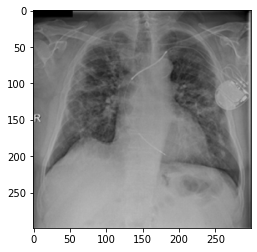

In [ ]:
test_image = cv2.imread(test_img[77])

#  RGB 바꾸고 255로 나눠서 normalize(훈련 때와 똑같은 이미지 처리 과정 거치기)
test_image_2 = test_image[:, :, ::-1] / 255.0


plt.imshow(test_image_2)

In [ ]:
# 혹시나 모르니 타입 확인

type(test_image_2)

numpy.ndarray

### 임의로 축을 하나 더 만들어서, 이 1장만 predict해 보겠습니다.

In [ ]:
# 임의로 맨 앞에 축 하나 더 만들기

t = test_image_2[np.newaxis, :]
t.shape

(1, 299, 299, 3)

In [ ]:
# 이 이미지는 COVID 환자의 data입니다.

test_img[77]

'./COVID-19_Radiography_Dataset/test/COVID/COVID-3593.png'

In [ ]:
model_3.predict(t)

array([[9.8961675e-01, 1.0378114e-02, 5.1655320e-06]], dtype=float32)

In [ ]:
# 제일 높은 값(이 클래스일 확률)이 무엇인지 봅시다.

np.argmax(model_3.predict(t))

0

### COVID-19으로 잘 predict한 것을 알 수 있습니다.
### 이제, heatmap을 띄워 봅시다.

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
# 레이어의 이름을 가져옵니다.

last_conv_layer_name = "conv2d_11"

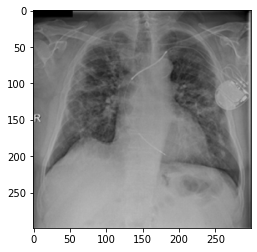

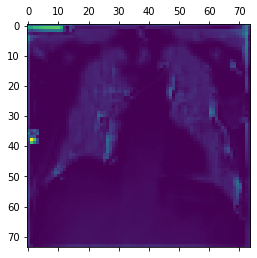

In [ ]:
# Generate class activation heatmap
heatmap = make_gradcam_heatmap(t, model_3, last_conv_layer_name)

# Display heatmap

plt.imshow(test_image_2)

plt.matshow(heatmap)
plt.show()

In [ ]:
np.max(heatmap)

1.0

참조 : 중간프로젝트 제출 가이드 pdf

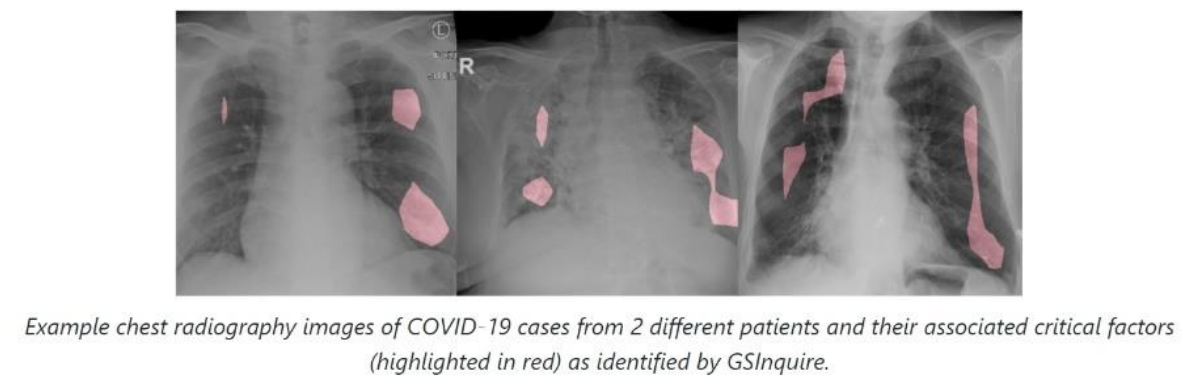

### 위와 비교해 보면, 사진과 비슷하게 가장자리에서 heatmap들이 잡혀 있는 걸 볼 수 있습니다.

다음으로 170번째 이미지를 불러와 보도록 하겠습니다.

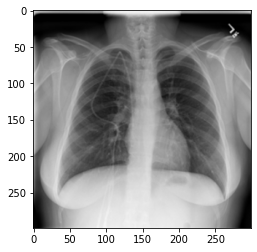

In [ ]:
# Normal subject의 data입니다.
test_image_3 = cv2.imread(test_img[170])

# 전처리
test_image_4 = test_image_3[:, :, ::-1] / 255.0


plt.imshow(test_image_4)

In [ ]:
t_2 = test_image_4[np.newaxis, :]
t_2.shape

(1, 299, 299, 3)

In [ ]:
model_3.predict(t_2)

array([[4.2437619e-06, 9.9999571e-01, 4.7385103e-11]], dtype=float32)

In [ ]:
np.argmax(model_3.predict(t_2))

1

### 1이므로, Normal로 분류한 것을 알 수 있습니다.

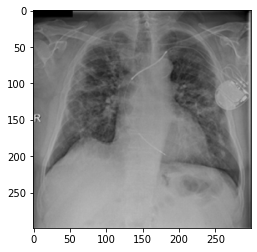

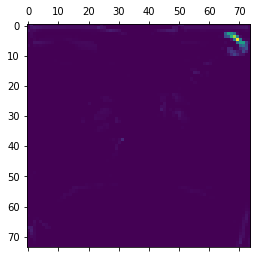

In [ ]:
# Generate class activation heatmap
heatmap = make_gradcam_heatmap(t_2, model_3, last_conv_layer_name)

# Display heatmap

plt.imshow(test_image_2)

plt.matshow(heatmap)
plt.show()

히트맵은 만족스럽진 않지만, 일단 정상 환자라고 분류를 제대로 한 것을 볼 수 있습니다.

### 마지막으로, 250번째 이미지를 불러와 봅시다.

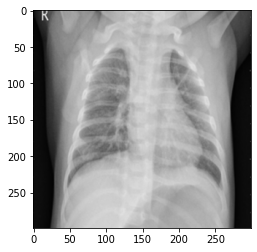

In [ ]:
# Viral pneumonia 환자의 data입니다.
test_image_5 = cv2.imread(test_img[250])

# 전처리
test_image_6 = test_image_5[:, :, ::-1] / 255.0


plt.imshow(test_image_6)

In [ ]:
t_3 = test_image_6[np.newaxis, :]
t_3.shape

(1, 299, 299, 3)

In [ ]:
model_3.predict(t_3)

array([[0.00206226, 0.00808588, 0.98985183]], dtype=float32)

In [ ]:
np.argmax(model_3.predict(t_3))

2

### 2이므로, Viral pneumonia로 분류한 것을 알 수 있습니다.

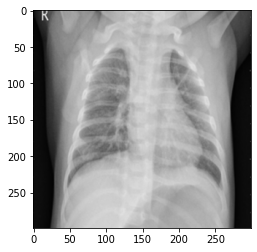

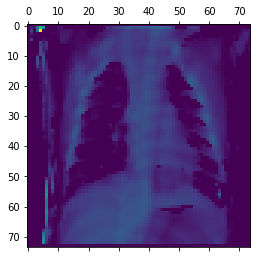

In [ ]:
# Generate class activation heatmap
heatmap = make_gradcam_heatmap(t_3, model_3, last_conv_layer_name)

# Display heatmap

plt.imshow(test_image_6)

plt.matshow(heatmap)
plt.show()

### 바이러스성 폐렴은 폐 전체적인 GGO가 특징이기 때문에, 이를 중심으로 히트맵이 있음을 볼 수 있었습니다!

# 9. 결론 및 보완점

간단한 Convolution layer를 쌓은 것만으로도 좋은 결과가 나온 것을 알 수 있었다.   
추후 VGG16 등의 classfication에 대해 충분한 양의 data로 학습된 model들의 층을 가져오면 더 좋은 결과를 낼 수 있을 것으로 생각된다.

In [ ]:
# 추후...
input_tensor = Input(shape=(150,150,3))

# 사전 학습된 모델 불러오기
model = VGG16(weights='imagenet', include_top=False, input_tensor = input_tensor)